<a href="https://colab.research.google.com/github/17092003vamsi/HUNTER/blob/main/KNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Accuracy: 0.95
Validation Accuracy: 0.95

Classification Report (Validation Set):
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        31
         A-S       1.00      1.00      1.00        32
           G       0.85      0.97      0.91        36
         G-S       0.93      1.00      0.96        27
         HPM       0.96      0.76      0.85        29
       HPM-S       0.97      0.94      0.95        32

    accuracy                           0.95       187
   macro avg       0.95      0.94      0.95       187
weighted avg       0.95      0.95      0.95       187



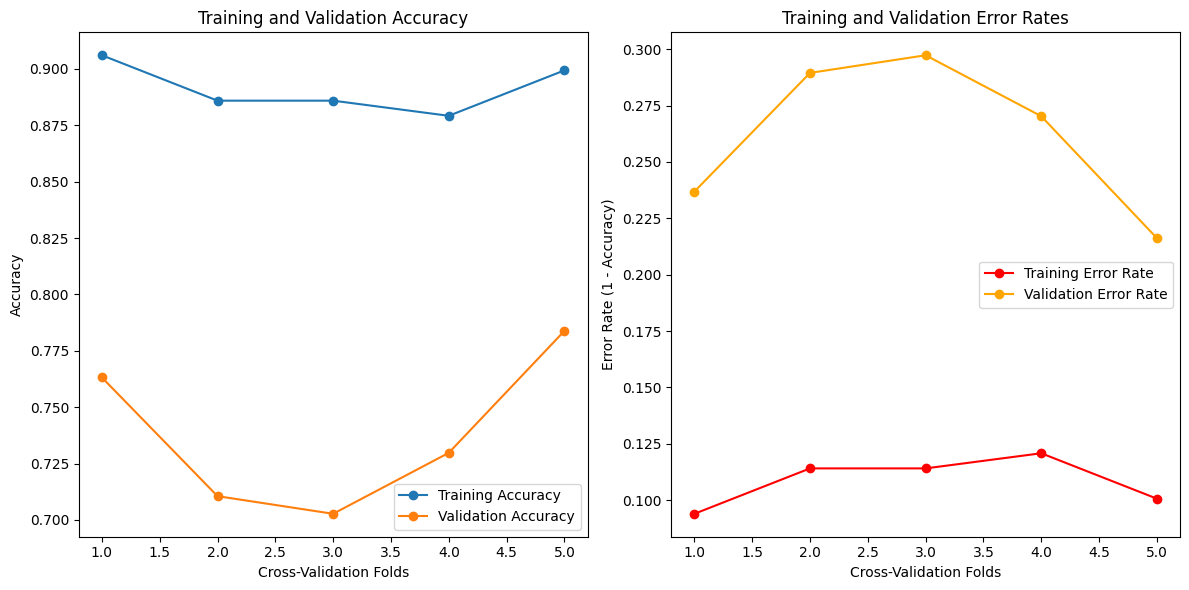

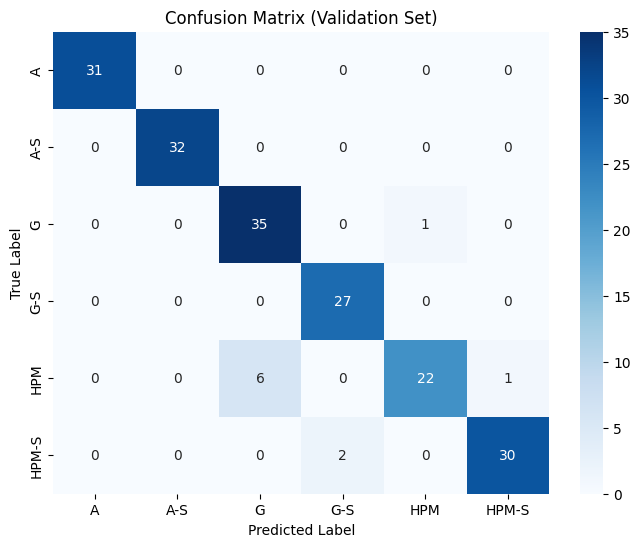

  0%|          | 0/187 [00:00<?, ?it/s]

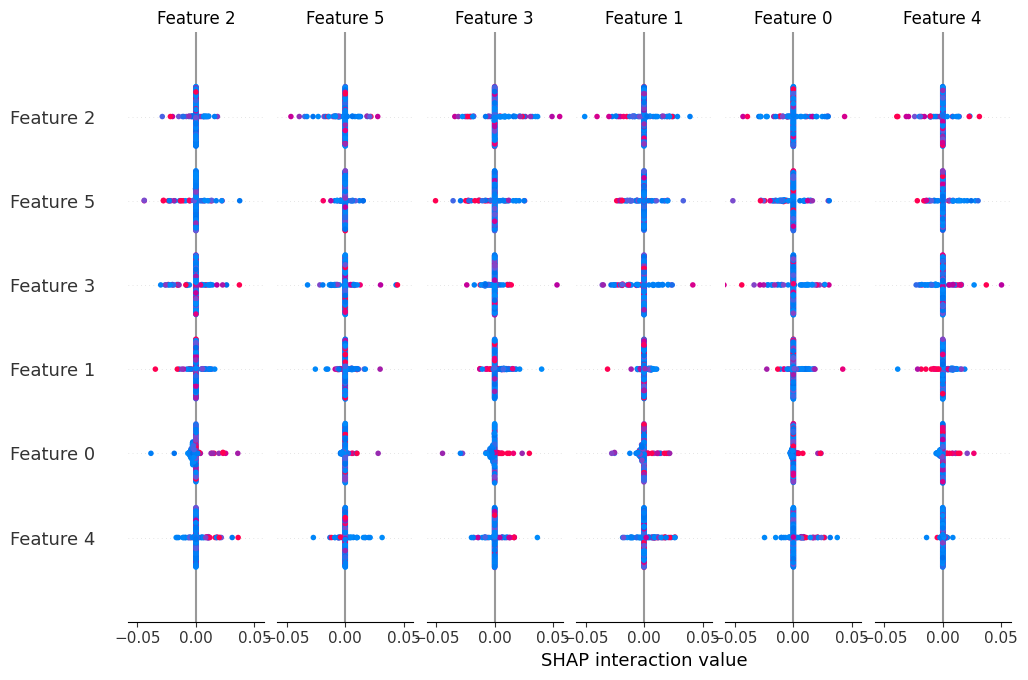

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap  # SHAP package for explainability
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Load the data
file_path = '/content/project 2 sap.csv'  # replace with the correct path to your CSV file
data = pd.read_csv(file_path)

# Separate features and target label
X = data.drop(columns=['Type', 'Lable'])
y = data['Lable']

# Handle missing values by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target labels into numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions and accuracy for both training and validation sets
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print Training and Validation Accuracy
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Print classification report for validation set with adjusted labels
unique_labels = np.unique(y_val)
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, labels=unique_labels, target_names=label_encoder.inverse_transform(unique_labels)))


# Cross-validation for training and validation accuracy and error rate
train_scores = cross_val_score(knn_model, X_train, y_train, cv=5)
val_scores = cross_val_score(knn_model, X_val, y_val, cv=5)

train_error_rates = 1 - train_scores
val_error_rates = 1 - val_scores
folds = np.arange(1, len(train_scores) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(folds, train_scores, label='Training Accuracy', marker='o')
plt.plot(folds, val_scores, label='Validation Accuracy', marker='o')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting Training and Validation Error Rates
plt.subplot(1, 2, 2)
plt.plot(folds, train_error_rates, label='Training Error Rate', marker='o', color='red')
plt.plot(folds, val_error_rates, label='Validation Error Rate', marker='o', color='orange')
plt.xlabel('Cross-Validation Folds')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.legend()
plt.title('Training and Validation Error Rates')

plt.tight_layout()
plt.show()

# Plotting Confusion Matrix with adjusted labels
unique_labels = np.unique(np.concatenate((y_val, y_val_pred)))
conf_matrix = confusion_matrix(y_val, y_val_pred, labels=unique_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.inverse_transform(unique_labels),
            yticklabels=label_encoder.inverse_transform(unique_labels))
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Initialize the SHAP explainer using KernelExplainer for non-tree models
explainer = shap.KernelExplainer(knn_model.predict_proba, shap.kmeans(X_train, 10))

# Calculate SHAP values for the validation set
shap_values_val = explainer.shap_values(X_val)

# SHAP summary plot for the validation set
shap.summary_plot(shap_values_val, X_val, plot_type="bar")
